# Predicción de Neumonía mediante una Red Neuronal

En este proyecto, desarrollaremounade red neonaloconvolucional con la libreria PyTorch,al para predecir si una persona tiene neumonía a partir de imágenes de radiografías de tórax

El DataSet utilizado pueden encontrarse en: https://data.mendeley.com/datasets/rscbjbr9sj/2 

Antes de comenzar, importaremos las bibliotecas necesarias para llevar a cabo este proyeto.


In [ ]:
import os
from efficientnet_pytorch import EfficientNet
from torchsummary import summary
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torchmetrics
from torch.optim import lr_scheduler
import timm

## Preprocesamiento de datos

Hacemos un vistazo al dataset:

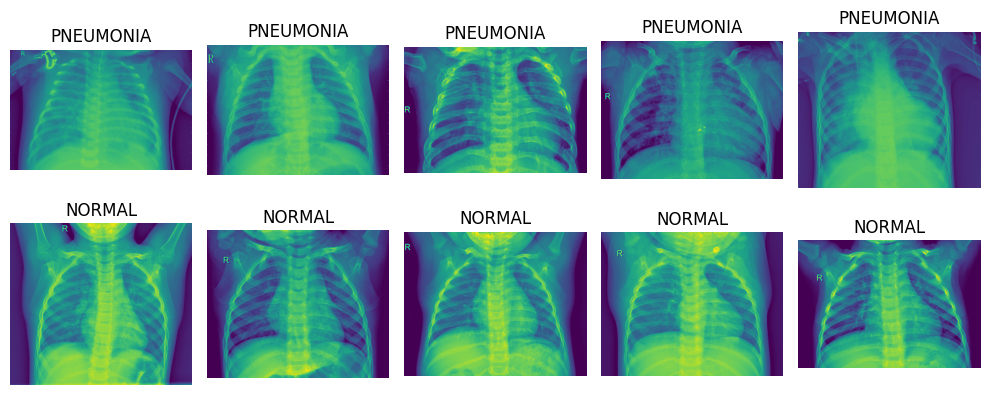

In [2]:
neumonia_folder = "chest_xray/train/PNEUMONIA"
normal_folder = "chest_xray/train/NORMAL"

neumonia_folder_test = "chest_xray/test/PNEUMONIA"
normal_folder_test = "chest_xray/test/NORMAL"

images_pneumonia = os.listdir(neumonia_folder)[:5]
images_normal = os.listdir(normal_folder)[:5]

plt.figure(figsize=(10, 10))
for i, imagen in enumerate(images_pneumonia):
    plt.subplot(5, 5, i+1)
    img = Image.open(os.path.join(neumonia_folder, imagen))
    plt.imshow(img)
    plt.axis('off')
    plt.title('PNEUMONIA')

for i, imagen in enumerate(images_normal):
    plt.subplot(5, 5, i+6)
    img = Image.open(os.path.join(normal_folder, imagen))
    plt.imshow(img)
    plt.axis('off')
    plt.title('NORMAL')

plt.tight_layout()
plt.show()

Los datos ya están separados lo que facilita su procesamiento:

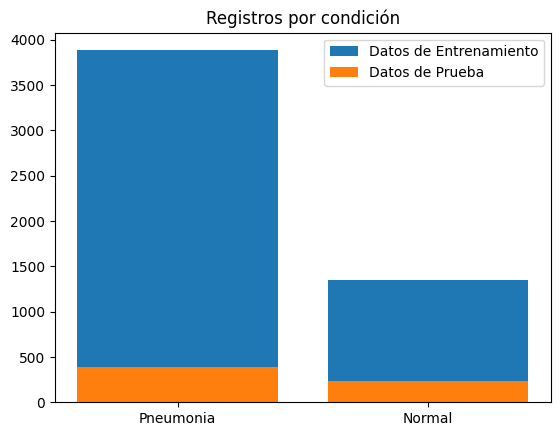

In [4]:
plt.bar(['Pneumonia','Normal'],[len(os.listdir(neumonia_folder)), len(os.listdir(normal_folder))], label = "Datos de Entrenamiento")
plt.bar(['Pneumonia','Normal'],[len(os.listdir(neumonia_folder_test)), len(os.listdir(normal_folder_test))], label = "Datos de Prueba")
plt.title("Registros por condición")
plt.legend()
plt.show()

Preparamos el set de entrenamiento y el set donde probaremos la red en el formato para interactuar con los modulos de torch:

In [4]:
train_path = "chest_xray/train"
test_path = "chest_xray/test"

transform = transforms.Compose([
    transforms.Grayscale(), # Aplicamos escala de grises para simplificar el modelo
    transforms.Resize((128, 128)),  # Ajustamos el tamaño de las imágenes a 256x256 píxeles
    transforms.ToTensor(),         # Convertimos las imágenes a tensores
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalizamos las imágenes
])

full_train_set = ImageFolder(train_path, transform=transform)

train_ratio = 0.8
val_ratio = 0.2
train_size = int(train_ratio * len(full_train_set))
val_size = len(full_train_set) - train_size

train_set, val_set = random_split(full_train_set, [train_size, val_size])

test_set = ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

## CNN Simple

Primero vamos a implementar una CNN con tres capas convolucionales y dos capas ReLU:

In [2]:
from networks import SimpleCNN

model = SimpleCNN()
summary(model, input_size = (1,128,128))

Ahora entrenamos la red:

In [19]:
modelo_simple = SimpleCNN()

criterio = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo_simple.parameters(), lr=0.01)

for j in range(10):
    modelo_simple.train()
    loss_sum = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = modelo_simple(images)
        loss = criterio(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    print(f"Iteración {j+1}/{10}, Loss: {loss_sum/len(train_loader)}")

torch.save(modelo_simple.state_dict(), 'modelo_simple.pth')

Iteración 1/10, Loss: 0.44881162501689864
Iteración 2/10, Loss: 0.4189123554927547
Iteración 3/10, Loss: 0.41184179666565685
Iteración 4/10, Loss: 0.403816085036208
Iteración 5/10, Loss: 0.40026724429392235
Iteración 6/10, Loss: 0.3856924058097165
Iteración 7/10, Loss: 0.39255191422090296
Iteración 8/10, Loss: 0.39291138656255675
Iteración 9/10, Loss: 0.3820218256697422
Iteración 10/10, Loss: 0.37051699946566324


Evaluamos el rendimiento de la red:

In [55]:
model = SimpleCNN()
model.load_state_dict(torch.load('modelo_simple.pth'))

binary_accuracy = torchmetrics.Accuracy(task = 'binary')

model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterio(outputs, labels)  
       
        predictions = outputs.argmax(dim = 1)   
        acc = binary_accuracy(predictions, labels)
      

print(f'Accuracy: {binary_accuracy.compute()}')

Accuracy: 0.7003205418586731


## ResNet-18

Vamos a intentar mejorar los resultados implementando una ResNet-18:

In [4]:
from networks import BasicBlock, ResNet

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])  

model = ResNet18()
summary(model, input_size = (1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 66, 66]             576
       BatchNorm2d-2           [-1, 64, 66, 66]             128
         MaxPool2d-3           [-1, 64, 34, 34]               0
              ReLU-4           [-1, 64, 34, 34]               0
            Conv2d-5           [-1, 64, 34, 34]          36,864
       BatchNorm2d-6           [-1, 64, 34, 34]             128
              ReLU-7           [-1, 64, 34, 34]               0
            Conv2d-8           [-1, 64, 34, 34]          36,864
       BatchNorm2d-9           [-1, 64, 34, 34]             128
       BasicBlock-10           [-1, 64, 34, 34]               0
           Conv2d-11           [-1, 64, 34, 34]          36,864
      BatchNorm2d-12           [-1, 64, 34, 34]             128
             ReLU-13           [-1, 64, 34, 34]               0
           Conv2d-14           [-1, 64,

Entrenamos la red

In [5]:
modelo = ResNet18()

criterion = nn.BCELoss()
optimizer = optim.Adam(modelo.parameters(), lr=0.02)

for j in range(10):
    modelo.train()
    losssum = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = modelo(images)
        outputs = outputs.squeeze(dim =-1)
        labels = labels.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losssum += loss.item()
    print(f"Iteracion {j+1}/{10}, Loss: {losssum/len(train_loader)}")

torch.save(modelo.state_dict(), 'resnet18v1.pth')

Iteracion 1/10, Loss: 0.29989297004280296
Iteracion 2/10, Loss: 0.18585969130622176
Iteracion 3/10, Loss: 0.14599004523010878
Iteracion 4/10, Loss: 0.12697909393052503
Iteracion 5/10, Loss: 0.10418208325054587
Iteracion 6/10, Loss: 0.1054843328325305
Iteracion 7/10, Loss: 0.08705303962796745
Iteracion 8/10, Loss: 0.07647225620770236
Iteracion 9/10, Loss: 0.07717420420433371
Iteracion 10/10, Loss: 0.0698898321574145


In [8]:
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

model = ResNet18()
model.load_state_dict(torch.load('resnet18v1.pth'))

binary_accuracy = torchmetrics.Accuracy(task = 'binary')


model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        labels = labels.float()
        outputs = outputs.squeeze(dim = 1) 
        loss = criterion(outputs, labels)  
        predictions = outputs   
        acc = binary_accuracy(predictions, labels)


print(f'Accuracy: {binary_accuracy.compute()}')

Accuracy: 0.8653846383094788


## EfficientNet con aumentacion

In [8]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.utils import resample
from efficientnet_pytorch import EfficientNet

class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for label, condition in enumerate(['NORMAL', 'PNEUMONIA']):
            condition_dir = os.path.join(root_dir, condition)
            for img_name in os.listdir(condition_dir):
                self.image_paths.append(os.path.join(condition_dir, img_name))
                self.labels.append(label)
                
        normal_indices = [i for i, label in enumerate(self.labels) if label == 0]
        pneumonia_indices = [i for i, label in enumerate(self.labels) if label == 1]

        if len(normal_indices) > len(pneumonia_indices):
            normal_indices = resample(normal_indices, replace=False, n_samples=len(pneumonia_indices), random_state=42)
        else:
            pneumonia_indices = resample(pneumonia_indices, replace=False, n_samples=len(normal_indices), random_state=42)

        balanced_indices = normal_indices + pneumonia_indices
        self.image_paths = [self.image_paths[i] for i in balanced_indices]
        self.labels = [self.labels[i] for i in balanced_indices]
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L') 
        image = np.array(image)
        image = np.stack([image] * 3, axis=-1) 
        if self.transform:
            image = self.transform(image=image)['image']
        
        label = self.labels[idx]
        return image, label

transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

train_dataset = ChestXRayDataset(root_dir="chest_xray/train", transform=transform)
test_dataset = ChestXRayDataset(root_dir="chest_xray/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


**Data Aumentation**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained('efficientnet-b0')
num_features = model._fc.in_features
model._fc = torch.nn.Linear(num_features, 2)  

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)  

best_accuracy = 0.0
early_stopping_patience = 3
no_improvement_epochs = 0

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    scheduler.step(running_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model2.pth')
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")

    print(f'Epoch [{epoch+1}/{10}], Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}%')

print('Training complete')
torch.save(model.state_dict(), 'final_model.pth')

## torch.save(model.state_dict(), 'model.pth') 90.1 accuracy